In [2]:
import pandas
import numpy
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
import pyarrow.parquet as pq
import folium
import numpy as np

/var/folders/fq/416crnp14t900prd5913_8700000gn/T/ipykernel_44056/504002386.py:4: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  souterrain_2023 = pandas.read_csv(path+'souterrain_2023.csv', sep=';')


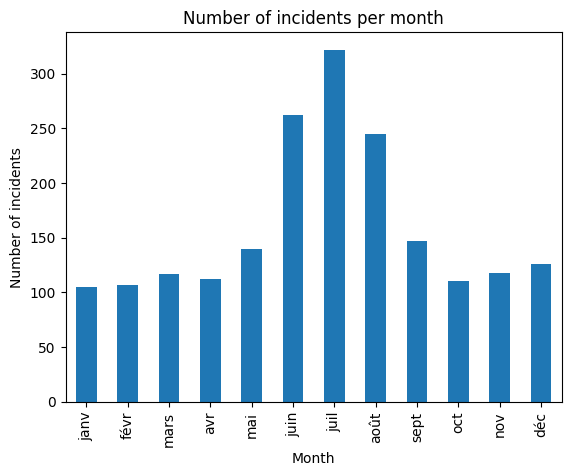

In [3]:
path = "data/"
# ouvrir les fichiers
incidents = pandas.read_csv(path+'donnees_incidents.csv', sep=';')
souterrain_2023 = pandas.read_csv(path+'souterrain_2023.csv', sep=';')
souterrain_troncons = pandas.read_csv(path+'souterrain_tronçons.csv', sep=';')
icu = pandas.read_csv(path+'icu.csv', sep=';')
temperatures = pq.read_table(path+'temperatures.parquet').to_pandas()
humidite = pq.read_table(path+'humidite.parquet').to_pandas()
nuages = pq.read_table(path+'nuages.parquet').to_pandas()

# plotly show number of incidents per month [january to december]
incidents_per_month = incidents.groupby('Mois (nom)').size()
# order months by chronological order
incidents_per_month = incidents_per_month.reindex(['janv', 'févr', 'mars', 'avr', 'mai', 'juin', 'juil', 'août', 'sept', 'oct', 'nov', 'déc'])
incidents_per_month.plot.bar()
plt.title('Number of incidents per month')
plt.xlabel('Month')
plt.ylabel('Number of incidents')
plt.show()

In [4]:
# show incidents on a map
# create a map
m = folium.Map(location=[45.75, 4.85], zoom_start=12)
# add incidents
for index, row in incidents.iterrows():
    try :
        folium.Marker([row['new_y'], row['new_x']], popup=row['Cause de l\'interruption']).add_to(m)
    except :
        print("error: ", row['new_x'], row['new_y'])
        pass
# add underground cables
for index, row in souterrain_2023.iterrows():
    try : 
        folium.PolyLine([[row['y0'], row['x0']], [row['y1'], row['x1']]], color="red", weight=2.5, opacity=1).add_to(m)
    except :
        print("error: ", row['x0'], row['y0'], row['x1'], row['y1'])
        pass


error:  nan nan
error:  nan nan
error:  nan nan
error:  nan nan
error:  nan nan


In [5]:
print(temperatures)
# date_valid     valeur  longitude  latitude
# 0       2014-01-01 00:00:00   6.712457        0.1      44.0
# 1       2014-01-01 01:00:00   6.176080        0.1      44.0

                 date_valid     valeur  longitude  latitude
0       2014-01-01 00:00:00   6.712457        0.1      44.0
1       2014-01-01 01:00:00   6.176080        0.1      44.0
2       2014-01-01 02:00:00   5.666040        0.1      44.0
3       2014-01-01 03:00:00   5.169031        0.1      44.0
4       2014-01-01 04:00:00   4.680322        0.1      44.0
...                     ...        ...        ...       ...
175195  2023-12-31 20:00:00   9.845117       -1.0      45.1
175196  2023-12-31 21:00:00  10.114893       -1.0      45.1
175197  2023-12-31 22:00:00  10.237451       -1.0      45.1
175198  2023-12-31 23:00:00  10.332361       -1.0      45.1
175199  2024-01-01 00:00:00   9.951166       -1.0      45.1

[24535000 rows x 4 columns]


In [6]:
# xgboost model to predict if there will be an incident or not on a given day (taking into account temperature)

# create a dataframe with the number of incidents per day (Année-Mois |  Semaine |  jour) and fill with 0 when there is no incident on a given day
incidents_per_day = incidents.groupby(['Année-Mois', 'Semaine', 'jour']).size()

incidents_per_day = incidents_per_day.reset_index()
incidents_per_day = incidents_per_day.rename(columns={0: 'Value'})
incidents_per_day['Année-Mois-jour'] = incidents_per_day['Année-Mois'] + '-' + incidents_per_day['jour'].astype(str)
incidents_per_day = incidents_per_day.drop(columns=['Année-Mois', 'Semaine', 'jour'])
incidents_per_day = incidents_per_day.set_index('Année-Mois-jour')

# add missing days with 0 value
start_date = incidents_per_day.index[0]
end_date = incidents_per_day.index[-1]
idx = pandas.date_range(start_date, end_date)
incidents_per_day.index = pandas.DatetimeIndex(incidents_per_day.index)
incidents_per_day = incidents_per_day.reindex(idx, fill_value=0)
incidents_per_day = incidents_per_day.reset_index()
incidents_per_day = incidents_per_day.rename(columns={'index': 'Année-Mois-jour'})
incidents_per_day['Année-Mois-jour'] = incidents_per_day['Année-Mois-jour'].astype(str)
incidents_per_day = incidents_per_day.set_index('Année-Mois-jour')
incidents_per_day = incidents_per_day.sort_index()
incidents_per_day.reset_index(inplace=True)

# create a dataframe with the temperature per day
temperatures_per_day = temperatures.groupby('date_valid').mean()
temperatures_per_day = temperatures_per_day.drop(columns=['longitude', 'latitude'])
temperatures_per_day.index = pandas.to_datetime(temperatures_per_day.index)
temperatures_per_day = temperatures_per_day.resample('D').mean()
temperatures_per_day = temperatures_per_day.dropna()
temperatures_per_day.reset_index(inplace=True)


In [7]:
# incidents_per_day["seuil"] = np.where(incidents_per_day > 1, 2, np.where(incidents_per_day > 0, 1, 0))
incidents_per_day["seuil"] = incidents_per_day["Value"].apply(lambda x: 0 if x == 0 else (1 if x == 1 else 2))

In [16]:
incidents_per_day.head()

,Année-Mois-jour,nb_incidents,seuil
0,2015-01-03,1,1
1,2015-01-04,1,1
2,2015-01-05,0,0
3,2015-01-06,0,0
4,2015-01-07,3,2


In [8]:
# incidents_per_day["seuil"] = np.where(incidents_per_day>1, 2, np.where(incidents_per_day>0, 1, 0))
# plt.figure(figsize=(15,5))
# plt.plot(incidents_per_day["seuil"])
# plt.xticks(range(0, len(incidents_per_day["seuil"]), 365),rotation=90)
# plt.title('Number of incidents per day')
# plt.xlabel('Date')
# plt.ylabel('Number of incidents')
# plt.show()

In [9]:
# plt.figure(figsize=(15,5))
# plt.plot(incidents_per_day)
# plt.xticks(range(0, len(incidents_per_day.index), 365),rotation=90)
# plt.title('Number of incidents per day')
# plt.xlabel('Date')
# plt.ylabel('Number of incidents')
# plt.show()

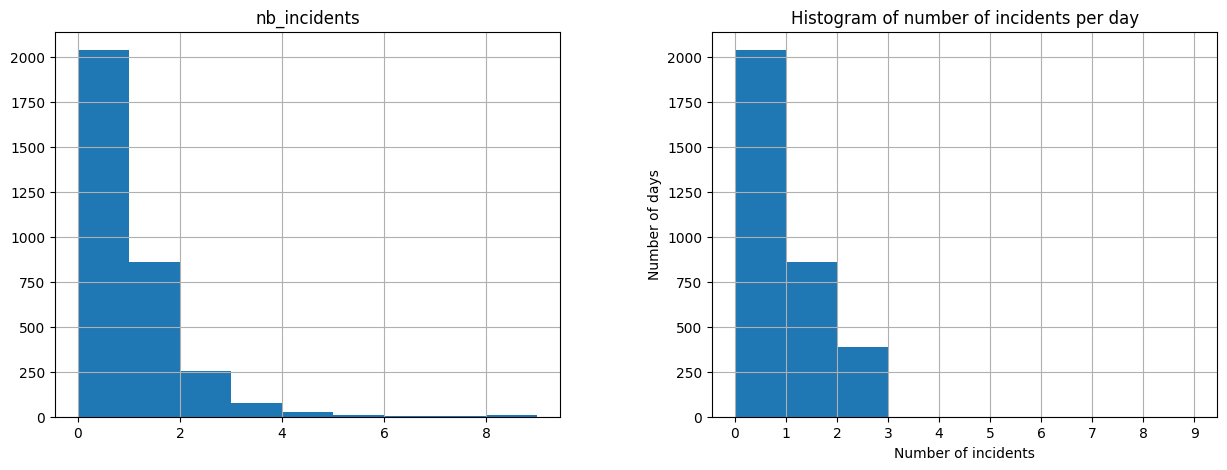

In [17]:
#show histogram of accident

incidents_per_day.hist(bins= range(10), figsize=(15,5))
plt.title('Histogram of number of incidents per day')
plt.xlabel('Number of incidents')
plt.xticks(range(10))
plt.ylabel('Number of days')
plt.show()

In [11]:
# import numpy as np
# # plot mean temperature per day
# plt.figure(figsize=(15,5))
# plt.plot(temperatures_per_day)
# plt.title('Mean temperature per day')
# plt.xlabel('Date')
# plt.ylabel('Mean temperature')
# plt.show()

In [12]:
humidite.rename(columns={"date_valid": 'Année-Mois-jour',"valeur": 'humidite'}, inplace=True)
nuages.rename(columns={"date_valid": 'Année-Mois-jour',"valeur": 'nuages'}, inplace=True)
# remove the H:MM:SS from the date
humidite['Année-Mois-jour'] = humidite['Année-Mois-jour'].str.split(' ').str[0].astype(str)
nuages['Année-Mois-jour'] = nuages['Année-Mois-jour'].str.split(' ').str[0].astype(str)


In [13]:
humidite_per_day = humidite.groupby('Année-Mois-jour').mean()
nuages_per_day = nuages.groupby('Année-Mois-jour').mean()

In [18]:
import pandas as pd
# Prepare dataframes so that column names match 
temperatures_per_day.rename(columns={"date_valid": 'Année-Mois-jour', 'valeur': 'temperature'}, inplace=True)
incidents_per_day.rename(columns={"Value": 'nb_incidents'}, inplace=True)

# Convert date to string for the merge
temperatures_per_day['Année-Mois-jour'] = temperatures_per_day['Année-Mois-jour'].astype(str)
# Merge the four dataframes on date column
incidents_and_temperatures_per_day = pd.merge(incidents_per_day, temperatures_per_day, on='Année-Mois-jour', how='left')
incidents_and_temperatures_per_day = pd.merge(incidents_and_temperatures_per_day, humidite_per_day, on='Année-Mois-jour', how='left')
incidents_and_temperatures_per_day = pd.merge(incidents_and_temperatures_per_day, nuages_per_day, on='Année-Mois-jour', how='left')

incidents_and_temperatures_per_day.drop(columns=['latitude_y', 'longitude_y'], inplace=True)
incidents_and_temperatures_per_day.rename(columns={"latitude_x": 'latitude', 'longitude_x': 'longitude'}, inplace=True)
incidents_and_temperatures_per_day.head()

,Année-Mois-jour,nb_incidents,seuil,temperature,humidite,longitude,latitude,nuages
0,2015-01-03,1,1,5.912898,93.768176,0.141429,44.8225,97.800992
1,2015-01-04,1,1,9.301486,95.745783,0.141429,44.8225,65.746025
2,2015-01-05,0,0,3.522026,95.898868,0.141429,44.8225,64.678316
3,2015-01-06,0,0,3.549924,96.674328,0.141429,44.8225,89.143881
4,2015-01-07,3,2,5.308433,95.563966,0.141429,44.8225,60.826242


In [19]:
# Save incidents_and_temperatures_per_day to csv
incidents_and_temperatures_per_day.to_csv('incidents_and_temperatures_per_day.csv', index=False)